## NOVA IMS - Universidade NOVA de Lisboa
### Data Science for Finance - Fixed Income
#### Individual Project

Hugo Laginha - 20231130@novaims.unl.pt

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install datetime
#!pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display
from datetime import datetime
from scipy.optimize import newton
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator, Akima1DInterpolator

In [3]:
data = {
    'Maturity Date': [
        '15/04/2019', '23/04/2019', '16/05/2019', '16/07/2019', '16/10/2019', 
        '16/04/2020', '16/10/2020', '16/04/2021', '19/04/2022', '17/04/2023', 
        '16/04/2024', '16/04/2025', '16/04/2026', '16/04/2027', '18/04/2028', 
        '16/04/2029', '16/04/2030', '16/04/2031', '17/04/2034', '18/04/2039', 
        '19/04/2044', '20/04/2049', '16/04/2054', '16/04/2059', '16/04/2064', 
        '16/04/2069'],
    'Market Rate (%)': [
        -0.36400/100, -0.37800/100, -0.36700/100, -0.31000/100, -0.23200/100, -0.22700/100, -0.19100/100, 
        -0.19925/100, -0.13050/100, -0.03975/100, 0.05525/100, 0.15425/100, 0.25650/100, 0.35725/100, 0.45825/100, 
        0.55240/100, 0.63850/100, 0.71650/100, 0.90100/100, 1.07100/100, 1.13400/100, 1.15200/100, 1.15000/100, 
        1.140249/100, 1.13100/100, 1.120999/100]
}

fixed_leg_details = {
    'notional': 10000000,
    'coupon_rate': 0.0005982,
    'payment_frequency': 1,  # Annual payments
    'day_count_convention': '30/360',
    'previous_payment_date': pd.to_datetime('2019-01-19'),
    'valuation_date': pd.to_datetime('2019-04-14'),
    'maturity_date': pd.to_datetime('2032-01-19')
}

floating_leg_details = {
    'notional': 10000000,
    'spread': 0.0000,
    'payment_frequency': 2,  # Semi-Annual payments
    'day_count_convention': 'ACT/360',
    'last_reset_date': pd.to_datetime('2018-10-19'),
    'valuation_date': pd.to_datetime('2019-04-14'),
    'current_reset_rate': -0.002360
}

df = pd.DataFrame(data)
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], dayfirst=True)
df.sort_values('Maturity Date', inplace=True)

Consider the Bloomberg information on a 25-year fixed rate receiver interest rate swap (IRS) contract issued on 19-01-2007 with floating leg linked to EURIBOR 6-month rate.

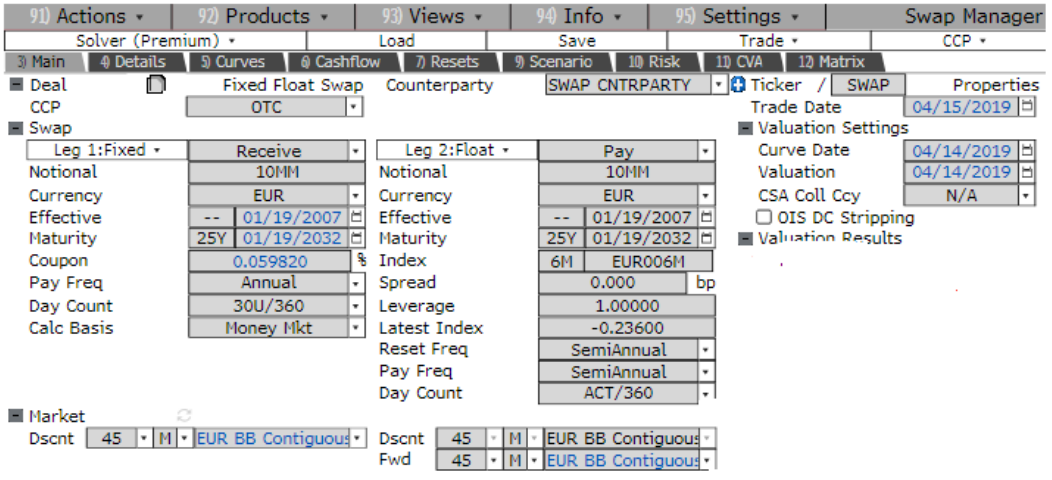

In [4]:
display(Image(filename='FIimage.png', width=750, height=450))

Consider the Bloomberg reference EUR yield curve on the valuation date 14-04-2019 as detailed below. Based on the market information:

In [5]:
df

,Maturity Date,Market Rate (%)
0,2019-04-15,-0.003640
1,2019-04-23,-0.003780
2,2019-05-16,-0.003670
3,2019-07-16,-0.003100
4,2019-10-16,-0.002320
5,2020-04-16,-0.002270
6,2020-10-16,-0.001910
7,2021-04-16,-0.001992
8,2022-04-19,-0.001305
9,2023-04-17,-0.000398


a) Build the complete yield curve using interpolation techniques.

**Answer:**

The yield curve is a graphical representation that shows the relationship between the interest rates (often referred to as the yield) and the time to maturity of debt securities. It is a crucial tool used by economists and investors to gauge the economic situation and to make investment decisions.

In practice, the yield curve does not provide interest rates for every possible maturity. Therefore, we employ interpolation techniques to estimate rates for maturities where market data is not available. Here we have used several interpolation methods:

- **Linear Interpolation**: This method assumes that the change between two points is linear and does not account for any possible curvature between them. Mathematically, the linear interpolation for a value \( y \) at point \( x \) between two known points \( (x_1, y_1) \) and \( (x_2, y_2) \) is given by the equation:

\[ y = y_1 + \frac{(y_2 - y_1)}{(x_2 - x_1)}(x - x_1) \]

- **Quadratic and Cubic Splines**: These methods fit polynomials of second or third degree, respectively, between each pair of data points. They are more flexible than linear interpolation and can better capture the curvature of the yield curve.

- **Piecewise Polynomial Interpolation (PCHIP)**: This method ensures that the interpolation is both smooth and monotonic, thereby preserving the shape of the data and avoiding the oscillations that can occur with high-degree polynomial fits.

- **Akima Interpolation**: This is a type of spline interpolation that is less sensitive to large variations in the slope of the data points. It is particularly useful when the data set contains outliers or abrupt changes in the derivative.

We have calculated these interpolated rates for a dense set of points along the period range to create a smooth curve that extends from the shortest to the longest maturities in our data set.

The following plot shows the original market data points and the yield curves obtained from each interpolation method. This visual comparison helps us to choose the most suitable interpolation for our analysis based on how well it fits the market rates and its behavior between data points.

In the following questions I decided to use the cubic spline.

In [6]:
periods = [(datetime.strptime(date, "%d/%m/%Y") - datetime.strptime(data['Maturity Date'][0], "%d/%m/%Y")).days for date in data['Maturity Date']]

In [7]:
linear_interpolator = interp1d(periods, data['Market Rate (%)'], kind='linear')
quadratic_spline_interpolator = interp1d(periods, data['Market Rate (%)'], kind='quadratic')
cubic_spline_interpolator = CubicSpline(periods, data['Market Rate (%)'])
PICHIP_Interpolator = PchipInterpolator(periods, data['Market Rate (%)'])
akima_interpolator = Akima1DInterpolator(periods, data['Market Rate (%)'])

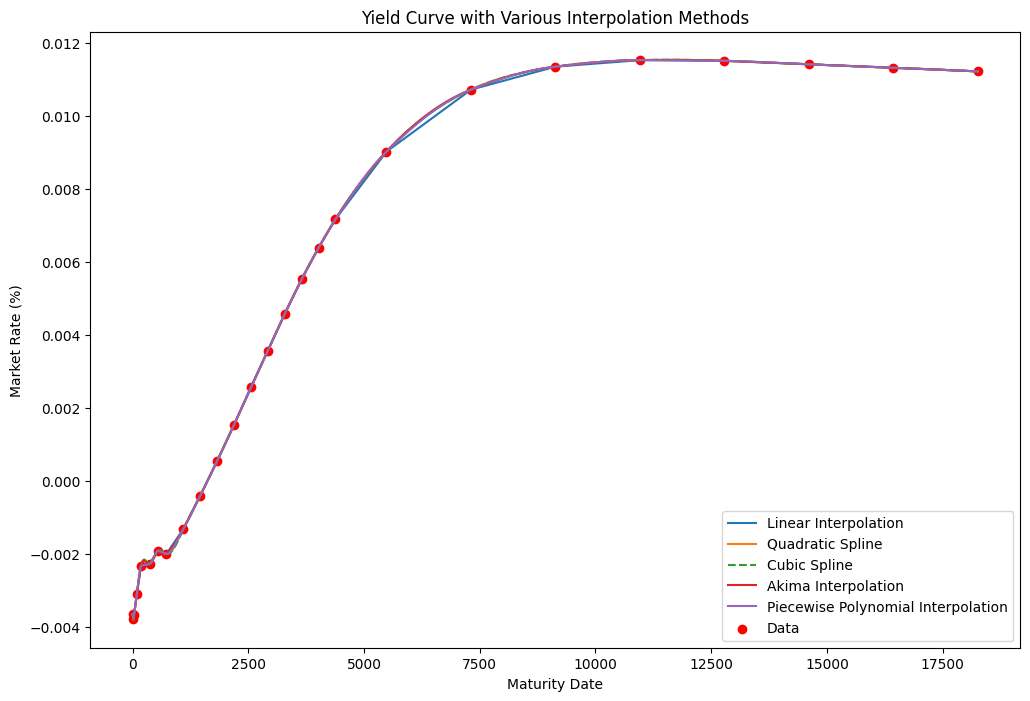

In [8]:
period_range = np.linspace(min(periods), max(periods), 1000)

int_rates_lin = linear_interpolator(period_range)
int_rates_quad = quadratic_spline_interpolator(period_range)
int_rates_cubsp = cubic_spline_interpolator (period_range)
int_rates_pichip = PICHIP_Interpolator(period_range)
int_rates_akima = akima_interpolator(period_range)

plt.figure(figsize=(12, 8))
plt.plot(period_range, int_rates_lin, label='Linear Interpolation')
plt.plot(period_range, int_rates_quad, label='Quadratic Spline')
plt.plot(period_range, int_rates_cubsp, label='Cubic Spline', linestyle='--')
plt.plot(period_range, int_rates_akima, label='Akima Interpolation')
plt.plot(period_range, int_rates_pichip, label='Piecewise Polynomial Interpolation')
plt.scatter(periods, data['Market Rate (%)'], color='red', label='Data')
plt.title('Yield Curve with Various Interpolation Methods')
plt.xlabel('Maturity Date')
plt.ylabel('Market Rate (%)')
plt.legend()
plt.show()

b) Compute the accrued interest in the fixed and floating legs of the contract.

**Answer:**

Accrued interest is the interest that accumulates on a bond or other fixed-income security between the payment periods. It is the amount of interest that has been earned but not yet paid to the bondholder. The calculation of accrued interest is necessary for a fair assessment of the current value of a financial instrument since it provides a measure of earned income that has yet to be realized.

For the **fixed leg** of an interest rate swap (IRS), the accrued interest is calculated using the formula:

$$ \text{Accrued Interest} = \frac{\text{Notional Amount} \times \text{Coupon Rate} \times \text{Day Count}}{360} $$

where:
- The **Notional Amount** is the principal amount on which the interest payments are based.
- The **Coupon Rate** is the annual interest rate paid by the security.
- The **Day Count** is the number of days since the last payment.

For the **floating leg**, the calculation is similar, but it also includes the **Spread** and the **Current Reset Rate**. The formula is:

$$ \text{Accrued Interest} = \frac{\text{Notional Amount} \times (\text{Current Reset Rate} + \text{Spread}) \times \text{Day Count}}{360} $$

In both cases, a 360-day year is assumed as per the day count convention specified in the contract details.

Using the provided code, the accrued interest for both legs of the contract was computed as follows:

- **Fixed Leg Accrued Interest**: €1412.42
- **Floating Leg Accrued Interest**: €-11603.33

The negative value for the floating leg indicates that the accrued interest is working against the holder of the floating leg due to the specifics of the interest rate environment or contract terms at the valuation date.


In [9]:
def calculate_fixed_accrued_interest(details):
    day_count = (details['valuation_date'] - details['previous_payment_date']).days
    interest = details['notional'] * details['coupon_rate'] * day_count / 360
    return interest

def calculate_floating_accrued_interest(details):
    day_count = (details['valuation_date'] - details['last_reset_date']).days
    interest = details['notional'] * (details['current_reset_rate'] + details['spread']) * day_count / 360
    return interest

In [10]:
# Calculate accrued interest for both legs
accrued_interest_fixed = calculate_fixed_accrued_interest(fixed_leg_details)
accrued_interest_floating = calculate_floating_accrued_interest(floating_leg_details)

# Display results
print(f"Accrued Interest Fixed Leg: {accrued_interest_fixed:.2f}")
print(f"Accrued Interest Floating Leg: {accrued_interest_floating:.2f}")

Accrued Interest Fixed Leg: 1412.42
Accrued Interest Floating Leg: -11603.33


c) Calculate the clean (principal) and dirty market value of the swap contract.

**Answer:**

To determine the market value of a swap, we need to calculate the present values (PV) of both the fixed and floating legs and then adjust for accrued interest to find the dirty and clean market values. Since this is a Euro-denominated swap, all values are expressed in EUR.

**Present Value of Floating Leg**
The floating leg's cashflows depend on the forward rates, which reflect the expected future EURIBOR rates determined from the yield curve. The cashflows are calculated as follows:

$$ \text{Cashflow}_{\text{floating}} = \text{Notional} \times \text{Forward Rate} \times \frac{\text{Day Count}}{360} $$

Each cashflow is discounted to its present value using the discount factor derived from the yield curve:

$$ \text{PV}_{\text{floating}} = \sum \frac{\text{Cashflow}_{\text{floating}}}{(1 + \frac{\text{Discount Rate}}{2})^{2 \times \text{Time to Payment}}} $$

Where Time to Payment is the time in years from the valuation date to each cash flow payment date.

**Present Value of Fixed Leg**
For the fixed leg, the cashflows are based on the agreed fixed coupon rate. The cashflows for the fixed leg are given by:

$$ \text{Cashflow}_{\text{fixed}} = \text{Notional} \times \text{Coupon Rate} $$

These cashflows are also discounted back to present value using discount factors calculated from the yield curve:

$$ \text{PV}_{\text{fixed}} = \sum \frac{\text{Cashflow}_{\text{fixed}}}{(1 + \text{Discount Rate})^{\text{Time to Payment}}} $$

**Clean and Dirty Market Value**
The **dirty market value** of the swap is the net present value of the fixed leg minus the net present value of the floating leg, adjusted for accrued interest:

$$ \text{Dirty Market Value} = \text{PV}_{\text{fixed}} - \text{PV}_{\text{floating}} + \text{Accrued Interest}_{\text{fixed}} + \text{Accrued Interest}_{\text{floating}} $$

The **clean market value**, is the dirty market value minus the accrued interest:

$$ \text{Clean Market Value} = \text{Dirty Market Value} - \text{Accrued Interest}_{\text{fixed}} - \text{Accrued Interest}_{\text{floating}} $$

Using the code provided, the calculated market values of the swap contract in EUR were:

- **Clean Market Value**: €8,205,734.83
- **Dirty Market Value**: €8,195,543.91

These market values represent the economic worth of the swap to the involved parties on the valuation date, with the clean market value providing a standardized measure for comparison across different swaps.

In [11]:
# Define the semi-annual frequency for reset dates
semi_annual_freq = pd.DateOffset(months=6)

# Calculate reset dates for the floating leg
floating_reset_dates = pd.date_range(
    start=floating_leg_details['last_reset_date'], 
    end=fixed_leg_details['maturity_date'], 
    freq=semi_annual_freq
)

# Use the first maturity date as the base for conversion
base_date = datetime.strptime(data['Maturity Date'][0], "%d/%m/%Y")

# Convert reset dates to a numerical format based on the base date
periods = [(reset_date.to_pydatetime() - base_date).days for reset_date in floating_reset_dates]

# Retrieve interpolated 6-month EURIBOR rates for the reset dates
interpolated_yields = [cubic_spline_interpolator(numerical_date) for numerical_date in periods]

# Utilize the most recent index rate as the first forward rate
interpolated_yields[0] = floating_leg_details['current_reset_rate']

# Define a function to calculate forward rates for each reset date
def compute_forward_rates(interpolated_rates, numerical_dates):
    forward_rates = [interpolated_rates[0]]  # Initialize with the most recent index rate
    for i in range(1, len(interpolated_rates)):
        days_in_year = 365
        start_period = numerical_dates[i - 1] / days_in_year
        end_period = numerical_dates[i] / days_in_year
        rate_start = interpolated_rates[i - 1]
        rate_end = interpolated_rates[i]
        
        # Calculate the forward rate, factoring in semi-annual compounding
        semi_annual_forward_rate = (
            ((1 + rate_end/2)**(2 * (end_period - start_period)) / 
             (1 + rate_start/2)**(2 * start_period))**(1 / (end_period - start_period)) - 1
        )
        semi_annual_forward_rate *= 2  # Annualize the forward rate
        forward_rates.append(semi_annual_forward_rate)
    
    return forward_rates

# Compute forward rates for floating leg
floating_forward_rates = compute_forward_rates(interpolated_yields, periods)

# Create DataFrame to display reset dates and their corresponding forward rates
forward_rates_display = pd.DataFrame({
    'Reset Date': [date.strftime("%Y-%m-%d") for date in floating_reset_dates],
    'Annualized Forward Rate': floating_forward_rates
})

forward_rates_display

,Reset Date,Annualized Forward Rate
0,2018-10-19,-0.002360
1,2019-04-19,-0.012045
2,2019-10-19,-0.004442
3,2020-04-19,0.000169
4,2020-10-19,0.005376
5,2021-04-19,0.007616
6,2021-10-19,0.012481
7,2022-04-19,0.015509
8,2022-10-19,0.014074
9,2023-04-19,0.011013


In [12]:
# Calculate cashflows and present value for the floating leg
def compute_cashflows_pv_floating_leg(reset_dates, forward_rates, notional, discount_rates, valuation_date):
    cashflows = []
    present_value = 0

    for period in range(1, len(reset_dates)):
        start_date = reset_dates[period - 1]
        end_date = reset_dates[period]
        days_count = (end_date - start_date).days
        cashflow = notional * forward_rates[period - 1] * days_count / 360

        time_to_payment = (end_date - valuation_date).days / 365
        discount_factor = (1 + discount_rates[period - 1] / 2)**(-2 * time_to_payment)

        pv_cashflow = cashflow * discount_factor
        present_value += pv_cashflow

        cashflows.append({
            'Payment Date': end_date.strftime("%Y-%m-%d"),
            'Forward Rate': forward_rates[period - 1],
            'Day Count Fraction': days_count / 360,
            'Cashflow': cashflow,
            'Discount Factor': discount_factor,
            'PV Cashflow': pv_cashflow
        })

    return cashflows, present_value

# Present value of floating leg
cashflows_floating_leg, present_value_floating_leg = compute_cashflows_pv_floating_leg(
    floating_reset_dates, 
    floating_forward_rates, 
    floating_leg_details['notional'], 
    interpolated_yields, 
    floating_leg_details['valuation_date']
)

# Display floating leg cashflows in a DataFrame
df_cashflows_floating = pd.DataFrame(cashflows_floating_leg)
print(f"Present Value of Floating Leg: {present_value_floating_leg:.2f}")
df_cashflows_floating

Present Value of Floating Leg: -8136126.00


,Payment Date,Forward Rate,Day Count Fraction,Cashflow,Discount Factor,PV Cashflow
0,2019-04-19,-0.002360,0.505556,-1.193111e+04,1.000032,-1.193150e+04
1,2019-10-19,-0.012045,0.508333,-6.122816e+04,1.001924,-6.134594e+04
2,2020-04-19,-0.004442,0.508333,-2.258033e+04,1.002346,-2.263329e+04
3,2020-10-19,0.000169,0.508333,8.568917e+02,1.003453,8.598507e+02
4,2021-04-19,0.005376,0.505556,2.718039e+04,1.003853,2.728513e+04
5,2021-10-19,0.007616,0.508333,3.871561e+04,1.005035,3.891053e+04
6,2022-04-19,0.012481,0.505556,6.309602e+04,1.005415,6.343767e+04
7,2022-10-19,0.015509,0.508333,7.883491e+04,1.004603,7.919777e+04
8,2023-04-19,0.014074,0.505556,7.114984e+04,1.003358,7.138876e+04
9,2023-10-19,0.011013,0.508333,5.598228e+04,1.001775,5.608167e+04


In [13]:
# Calculate the PV of the fixed leg cashflows and the discount factors
def calc_fixed_leg_cashflows_pv(fixed_leg_details, yield_curve_func):
    # Generate payment dates for the fixed leg based on annual frequency
    payment_dates_fixed = pd.date_range(start=fixed_leg_details['previous_payment_date'] + pd.DateOffset(years=1), end=fixed_leg_details['maturity_date'], freq='A')

    # Numerical conversion of payment dates for interpolation
    numerical_payment_dates_fixed = [(date.to_pydatetime() - base_date).days for date in payment_dates_fixed]

    # Compute cashflow for each period and discount to present value
    pv_fixed_leg = 0
    cashflows_details = []
    for i, payment_date in enumerate(payment_dates_fixed):
        cashflow = fixed_leg_details['notional'] * fixed_leg_details['coupon_rate']
        time_to_payment = (payment_date - fixed_leg_details['valuation_date']).days / 360
        discount_rate = yield_curve_func(numerical_payment_dates_fixed[i])
        discount_factor = (1 + discount_rate)**(-time_to_payment)
        pv_cashflow = cashflow * discount_factor
        pv_fixed_leg += pv_cashflow

        cashflows_details.append({
            'Date': payment_date,
            'Cashflow': cashflow,
            'Discount Factor': discount_factor,
            'Present Value': pv_cashflow
        })

    return pv_fixed_leg, pd.DataFrame(cashflows_details)

In [14]:
# Calculate the PV of the fixed leg
pv_of_fixed_leg, fixed_leg_cashflows_df = calc_fixed_leg_cashflows_pv(
    fixed_leg_details, 
    cubic_spline_interpolator
)
print(f"Present Value of Fixed Leg: {pv_of_fixed_leg:.2f}")
fixed_leg_cashflows_df

Present Value of Fixed Leg: 69608.83


,Date,Cashflow,Discount Factor,Present Value
0,2020-12-31,5982.0,1.003321,6001.866995
1,2021-12-31,5982.0,1.004445,6008.587735
2,2022-12-31,5982.0,1.002483,5996.851403
3,2023-12-31,5982.0,0.998724,5974.364494
4,2024-12-31,5982.0,0.992774,5938.772233
5,2025-12-31,5982.0,0.984682,5890.369988
6,2026-12-31,5982.0,0.974687,5830.579815
7,2027-12-31,5982.0,0.962889,5759.999280
8,2028-12-31,5982.0,0.949620,5680.629812
9,2029-12-31,5982.0,0.935579,5596.631077


In [15]:
# Calculate the dirty and clean market values of the swap
def calculate_market_values(pv_fixed_leg, pv_floating_leg, accrued_interest_fixed, accrued_interest_floating):
    # Dirty market value is the PV of fixed leg minus PV of floating leg plus accrued interests
    dirty_value = pv_fixed_leg - pv_floating_leg + accrued_interest_fixed + accrued_interest_floating
    
    # Clean market value is the dirty market value minus the sum of the accrued interests
    clean_value = dirty_value - (accrued_interest_fixed + accrued_interest_floating)
    
    return clean_value, dirty_value

# Compute market values
clean_market_val, dirty_market_val = calculate_market_values(
    pv_of_fixed_leg, 
    present_value_floating_leg, 
    accrued_interest_fixed, 
    accrued_interest_floating
)

print(f"Clean Market Value: {clean_market_val:.2f}")
print(f"Dirty Market Value: {dirty_market_val:.2f}")

Clean Market Value: 8205734.83
Dirty Market Value: 8195543.91


d) Estimate the net present value of the contract

**Answer:**

The Net Present Value (NPV) of a swap contract is a financial metric that represents the difference in value between the fixed leg and the floating leg of the swap. It reflects the current worth of all future cash flows that each party expects to receive or pay. In this context, the NPV helps us understand the value of the swap from one party's perspective at the valuation date.

The NPV is calculated by subtracting the present value (PV) of payments to be made from the PV of payments to be received. For a fixed rate receiver swap, the NPV formula is given by:

$$ \text{NPV} = \text{PV}_{\text{fixed leg}} - \text{PV}_{\text{floating leg}} $$

Where:
- $\text{PV}_{\text{fixed leg}} $ is the present value of the fixed leg cash flows, and
- $\text{PV}_{\text{floating leg}}$ is the present value of the floating leg cash flows.

In the given Euro-denominated swap contract, the calculated NPV is:

$$\text{Net Present Value of the Swap Contract} = 8205734.83 \text{ EUR} $$

This value signifies the economic benefit that the fixed rate receiver gains from the swap contract at the valuation date. If the NPV is positive, the contract is favorable to the fixed rate receiver. Conversely, a negative NPV would indicate a benefit to the floating rate payer.


In [16]:
# Estimate the net present value of the swap contract
def estimate_npv_swap_contract(pv_fixed_leg, pv_floating_leg):
    # Net Present Value (NPV) is the difference between the present values of the fixed and floating legs
    npv = pv_fixed_leg - pv_floating_leg
    return npv

In [17]:
net_present_value = estimate_npv_swap_contract(pv_of_fixed_leg, present_value_floating_leg)
print(f"Net Present Value of the Swap Contract: {net_present_value:.2f} EUR")

Net Present Value of the Swap Contract: 8205734.83 EUR


e) Estimate the swap par rate

**Answer:**

The swap par rate is the fixed interest rate at which the present value of the fixed leg cash flows equals the present value of the floating leg cash flows. In essence, it is the rate that makes the swap's net present value (NPV) equal to zero at inception. This rate is essential for swap pricing and comparative analysis.

The par rate can be determined using the following iterative method, typically employing Newton-Raphson numerical technique for finding roots:

1. Calculate the present value of the fixed leg for a given swap rate.
2. Adjust the swap rate such that the difference between the present value of the fixed leg and the floating leg is zero.

Mathematically, the par rate (\( r_{\text{par}} \)) can be found by solving the equation:

$$ \sum_{i=1}^{n} \left( \text{Notional} \times r_{\text{par}} \times DF_i \right) = \text{PV}_{\text{floating leg}}$$

where:
- $DF_i $ is the discount factor for the i-th payment date,
- $\text{Notional} $ is the notional amount of the swap,
- $\text{PV}_{\text{floating leg}} $ is the present value of the floating leg.

By applying this process to the provided market data and discount factors, the swap par rate is calculated to be:

$$\text{Swap Par Rate} = -0.069920$$

This negative par rate indicates that, given the current market conditions and discount factors, the fixed rate that would make the swap value zero is negative. This outcome is reflective of the prevailing low or negative interest rate environment in the Eurozone at the time of valuation.


In [18]:
# Function to calculate the present value of fixed leg cashflows given a swap rate
def calculate_fixed_leg_pv(rate, discount_factors, notional):
    return sum([notional * rate * df for df in discount_factors])

# Function to find the rate that equates the present value of the fixed leg to the PV of the floating leg
def find_par_rate(floating_leg_pv, fixed_leg_notional, discount_factors):
    # Inner function to compute the difference between fixed leg PV and floating leg PV
    def objective_function(rate):
        fixed_leg_pv = calculate_fixed_leg_pv(rate, discount_factors, fixed_leg_notional)
        return fixed_leg_pv - floating_leg_pv

    # Initial guess for the par rate could be an average of the observed market rates
    initial_guess = np.mean(data['Market Rate (%)'])
    
    # Use Newton's method to find the root of the objective function
    par_rate = newton(func=objective_function, x0=initial_guess)
    
    return par_rate

fixed_discount_factors = fixed_leg_cashflows_df['Discount Factor'].tolist()
# Calculate the swap par rate
swap_par_rate = find_par_rate(present_value_floating_leg, fixed_leg_details['notional'], fixed_discount_factors)

# Print the swap par rate
print(f"Swap Par Rate: {swap_par_rate:.6f}")

Swap Par Rate: -0.069920


f) Estimate the following IRS Greeks: present value of a one basis point shift (PV01), DV01, Gamma and discuss the interest rate risk of the contract.

**Answer:**

Interest rate swaps (IRS) Greeks are measures of the sensitivity of the swap's value to changes in underlying interest rate movements. Specifically, the following are calculated:

**PV01 (Present Value of a Basis Point)**
PV01 measures the change in the swap's value for a one basis point (0.01%) parallel shift in the yield curve. It is a first-order (linear) measure of interest rate risk. The formula for PV01 is:

$$ PV01 = \frac{PV_{\text{up}} - PV_{\text{down}}}{2} $$

where $PV_{\text{up}} $ and $PV_{\text{down}}$ are the present values of the swap after the yield curve is shifted up and down by one basis point, respectively.

**DV01 (Dollar Value of a 01)**
DV01, also known as "dollar duration," represents the monetary change in the swap's value per one basis point change in interest rates. It is equivalent to PV01 when the notional amount is in the same currency as the calculated PV01.

**Gamma**
Gamma measures the curvature of the swap's value in relation to interest rate movements and is a second-order (quadratic) risk measure. It indicates the rate of change of PV01 as the yield changes and is computed as:

$$\Gamma = \frac{PV01_{\text{up shift}} - PV01}{\text{shift size}} $$

A higher Gamma indicates a larger change in PV01 for interest rate movements, signifying greater convexity and thus, more pronounced non-linear interest rate risk.

**Discussion**
The IRS Greeks provide valuable insights into the contract's sensitivity to interest rate changes. A positive PV01 implies that the swap's value increases as rates fall, and vice versa. A large absolute Gamma value suggests that small changes in interest rates could lead to significant changes in the swap's market value, indicating higher interest rate risk.

In the present calculation, the swap exhibits a PV01 of 218736.69 EUR, meaning that for each basis point increase in interest rates, the swap's value decreases by this amount. The Gamma value of -1095915879.71 indicates a high sensitivity of PV01 to interest rate changes, reflecting significant interest rate risk for this IRS contract.


In [19]:
def recalculate_shifted_pvs(fixed_details, floating_details, yield_curve_func, current_date, basis_pt_shift):
    # Adjust the yield curve by the specified basis point shift
    adjusted_yield_curve = lambda x: yield_curve_func(x) + basis_pt_shift

    # Recalculate the fixed leg's PV with the adjusted yield curve
    fixed_leg_pv_adjusted, _ = calc_fixed_leg_cashflows_pv(fixed_details, adjusted_yield_curve)

    # Adjust the yields and recalculate the floating leg's PV
    adjusted_yields = [adjusted_yield_curve(date) for date in periods]
    shifted_fw_rates = compute_forward_rates(adjusted_yields, periods)
    _, floating_leg_pv_adjusted = compute_cashflows_pv_floating_leg(floating_reset_dates, shifted_fw_rates, floating_details['notional'], adjusted_yields, current_date)

    # The adjusted total PV is the difference between the fixed and floating leg's PVs
    total_pv_adjusted = fixed_leg_pv_adjusted - floating_leg_pv_adjusted

    return total_pv_adjusted

In [20]:
# Calculate the PV for both legs with a shift in the yield curve
valuation_day = fixed_leg_details['valuation_date']
upward_shift = 0.0001  # A shift of +1 basis point
downward_shift = -0.0001  # A shift of -1 basis point

total_pv_positive_shift = recalculate_shifted_pvs(fixed_leg_details, floating_leg_details, cubic_spline_interpolator, valuation_day, upward_shift)
total_pv_negative_shift = recalculate_shifted_pvs(fixed_leg_details, floating_leg_details, cubic_spline_interpolator, valuation_day, downward_shift)

# PV01 is the sensitivity of the portfolio's PV to a 1 basis point shift
pv01 = (total_pv_positive_shift - total_pv_negative_shift) / 2

# DV01 is the monetary value of PV01
dv01 = pv01

print(f"PV with Yield Curve Up: {total_pv_positive_shift}")
print(f"PV with Yield Curve Down: {total_pv_negative_shift}")
print(f"PV01 (for both legs): {pv01}")
print(f"DV01 (for both legs): {dv01}")

PV with Yield Curve Up: 6523667.078567744
PV with Yield Curve Down: 6086193.701036425
PV01 (for both legs): 218736.68876565946
DV01 (for both legs): 218736.68876565946


In [21]:
# Calculate Gamma, the second derivative of the portfolio's value with respect to yield changes
extra_shift = 0.00001
pv01_with_extra_shift = (recalculate_shifted_pvs(fixed_leg_details, floating_leg_details, cubic_spline_interpolator, valuation_day, upward_shift + extra_shift) -
                         recalculate_shifted_pvs(fixed_leg_details, floating_leg_details, cubic_spline_interpolator, valuation_day, extra_shift)) / 2
gamma = (pv01_with_extra_shift - pv01) / 0.0001

print(f"Gamma (for both legs): {gamma}")

Gamma (for both legs): -1095915879.7139115
